# Project Question

> Create a search function to search in a NAS space for the best performing **CNN architecture** on fashion-mnist.

Your task is to create a search function which searches for the model genome string that provides the best accuracy while using the least number of parameters.

Your program will return a model genome string (described below) which can be fed to a train function (provided below) to get the lowest parameter count and best accuracy after training.

**This is an open research problem**. You can use any method to search for the best genome and there might not be a perfect solution possible (prefect in the sense of maximum accuracy with minimum parameters). You will likely find tradeoffs between accuracy and number of parameters and you must balance such tradeoffs at your discretion.

> Aim for a search function that finds a genome with accuracy at least 75%.

You are encouraged to experiment with different techniques and apply your intuition to find a good search algorithm.

## CNN Architecture Constraints

Your search algorithm should search for models with the following basic structure.

Sequential model (no skip connections) having the following layers,
- Any number of normal(NC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A normal CNN layer has the following constraints,
    - `stride=1`
    - `padding=same`
    - `1 <= kernel size < 8`
    - Any of the following activation functions,
      - relu
      - sigmoid
      - tanh
      - swish
      - gelu
- **Exactly** 2 reduction(RC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A reduction layer has the **same** constraints as the normal layer except the following,
    - `stride=2`
    - `padding=valid`
- **Exactly** the following structure as the **final layers**,
  - First, a Global Average Pooling 2D layer.
    - `torch.nn.AvgPool2d(kernel_size=layer_input_image_size)` or `tf.keras.layers.GlobalAveragePooling2D`
  - Then, a Fully Connected/Dense layer with 64 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(64)` or `tf.keras.layers.Dense(64)`
  - Then, a Fully Connected/Dense layer with 10 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(10)` or `tf.keras.layers.Dense(10)`


The normal(NC) and reduction(RC) layers can be in **any order** as long as the constraints above are maintained.

The final layers of you model should be exactly as mentioned in these constraints.

All of the above contraints **apply only to your final output**. During searching for the best architecture you can do whatever you want.

Once your algorithm finds the best architecture, it should represent the architecture as a genome string (explained below) which will be fed to the training function given below to get the final accuracy.

In [23]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.1 MB/s 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


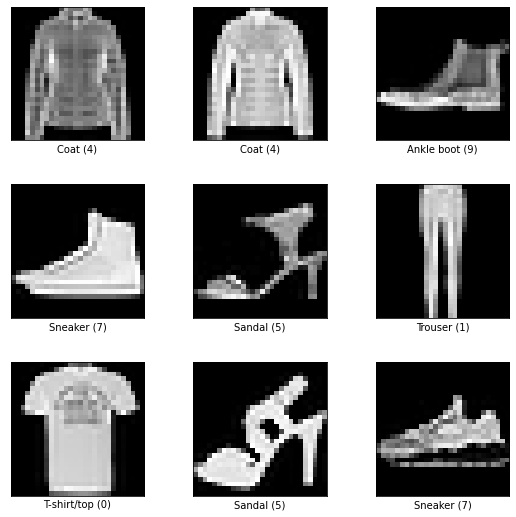

In [24]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [26]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 10)        100       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 20)        1820      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 10)          1810      
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [27]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=10,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

In [ ]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 

# __fr_model_genome = "NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;" #@param {type:"string"}
__fr_model_genome = "NC 32 1 swish;RC 32 2 tanh;RC 32 2 tanh;FL relu;"


#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  result = train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay)
  print('Return value:', result)
except Exception as e:
  print(e)
  print()
  # print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 32 1 swish;RC 32 2 tanh;RC 32 2 tanh;FL relu;
Model params: 11082
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 32)        64        
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 32)        4128      
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 32)          4128      
                                                                 
 global_average_pooling2d_6   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.5375999808311462
Return value: (0.5375999808311462, 0.5408833622932434, 11082)


In [ ]:
#@title Deep model genome example
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;
Model params: 607946
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 64)        128       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 64)        4160      
                                                                 
 Layer_3_RC (Conv2D)         (None, 13, 13, 128)       73856     
                                                                 
 Layer_4_NC (Conv2D)         (None, 13, 13, 128)       16512     
                                                                 
 Layer_5_NC (Conv2D)         (

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8525000214576721
Return value: (0.8525000214576721, 0.8599500060081482, 607946)


## Hints

- Consider caching genome results for faster querying.
  - This has a risk. The training process itself is non-deterministic and thus training the same genome multiple times can sometimes give drastically different results. Generally such difference in accuracy of the same genome is small but sometimes it be upto 30%.
- Consider saving your search algorithm state such that it can resume from a previous search point if it gets interrupted due to a crash or colab time restrictions.
  - Google colab is free and hence it has time limits on how long you can use the GPU. If you implement checkpointing in your code such that it saves checkpoints on your GDrive, you can save a lot of time when such interruptions happen.
  - You can mount your GDrive to colab and save/load files from your drive folders.
- Don't forget to enable GPU in colab.
  - https://colab.research.google.com/notebooks/gpu.ipynb
- If colab shows errors in code that was working before try to do `Runtime->Restart Runtime`. This is especially true if you stopped execution while a model was being trained.
  - You can also try `Runtime->Factory Reset Runtime` to get a clean slate (revert installed libraries to colab defaults).

# Answer
Write your answer and its code under this section.

In [28]:
def training_Model(__fr_model_genome): 
  # __fr_model_genome = "" 
  __fr_lr = 1e-3
  __fr_lr_decay = 0.1

  try:
    rr = train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay)
    print('Return value:', rr)
  except Exception as e:
    print(e)
    print()
    print(f'Your input genome: {__fr_model_genome}')

  return rr

In [ ]:
# x=training_Model('NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;')
# print(x)

In [33]:
import random
# dataset = [ 'NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;', 'NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;',
#            'RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;']
# dataset

In [30]:
import pandas as pd
dataset = pd.read_csv('/content/sample_data/GDataset.csv')
dataset = dataset['genome string']
print(dataset[1])

NC 32 1 swish;RC 32 2 tanh;RC 32 2 tanh;FL relu;


In [31]:
def getHeuristic(genome,idx):
  if model_Accuracy[idx]==0:
    #Train model and get accuracy and parameters used
    print("String",genome)
    m = training_Model(genome)
    accuracy = m[1]
    parameters = m[2]
    model_Accuracy[idx] = accuracy
    model_Parameters[idx] = parameters
  else:
    accuracy = model_Accuracy[idx]
    parameters = model_Parameters[idx]
  return accuracy,parameters;


In [35]:
n=len(dataset)
print(n)
model_Accuracy = [0]*(n)
# model_Accuracy = [0.79,0.8,0.08,0.79,0.99,0.15,0.22,0.91,1,0.5]
model_Parameters = [0]*(n)
visited = [0]*(n)

19


In [36]:
#@title
goal_Accuracy=0.75
idx = random.randint(0,n-1)
print(idx)

initial_Accuracy=0.0
count=0

#Store index traversed
path = []
path.append(idx)
visited[idx] = 1

while (initial_Accuracy <= goal_Accuracy) and (count < 15):
  count = count + 1
  print("Current index:",idx)
  #current
  acc, para = getHeuristic(dataset[idx],idx)
  #prev
  p_idx = (idx-1)%n
  p_acc, p_para = getHeuristic(dataset[p_idx],p_idx)
  p_Cost = (para - p_para) + p_acc    # Objective: Maximize this value  (Considering -ve weights also)
  print( p_idx,"iteration cost", p_Cost)
  #next
  n_idx = (idx+1)%n
  n_acc, n_para = getHeuristic(dataset[n_idx],n_idx)
  n_Cost = (para - n_para) + n_acc
  print(n_idx,"iteration cost", n_Cost)


  #Choose direction with respect to max cost
  if visited[p_idx]==1 and visited[n_idx]==0:
    print("Next",n_idx,n_Cost)
    if acc < n_acc or acc <= 0.75 :
      initial_Accuracy = n_acc
      idx = n_idx
    else:
      initial_Accuracy = acc

  if visited[p_idx]==0 and visited[n_idx]==1:
    print("Prev",p_idx,p_Cost)
    if acc < p_acc or acc <= 0.75:
      initial_Accuracy = p_acc
      idx = p_idx
    else:
      initial_Accuracy = acc

  if visited[p_idx]==0 and visited[n_idx]==0:
    if(n_Cost - p_Cost >= 0):
      print("Next",n_idx,n_Cost)
      if acc < n_acc or acc <= 0.75 :
        initial_Accuracy = n_acc
        idx = n_idx
      else:
        initial_Accuracy = acc
    else:
      print("Prev",p_idx,p_Cost)
      if acc < p_acc or acc <= 0.75:
        initial_Accuracy = p_acc
        idx = p_idx
      else:
        initial_Accuracy = acc
  
  if visited[p_idx]==1 and visited[n_idx]==1:
    print("END")
    path.append(idx)
    visited[idx] = 1
    break;
  
  path.append(idx)
  visited[idx] = 1

  #Update goal accuracy
  # if(goal_Accuracy < initial_Accuracy):
  #   goal_Accuracy = initial_Accuracy

print("Index followed",path)
if count >= 15:
  print("Can't find solution in defined Iterations")
  # print("Model Found:", dataset[idx], "with Accuracy", initial_Accuracy)
else:
  print("Iterations Req",count)
  print("Best Model Found:", dataset[idx], "with Accuracy", initial_Accuracy)


17
Current index: 17
String RC 20 3 relu;NC 10 3 tanh;RC 20 3 relu;FL sigmoid;
Training genome: RC 20 3 relu;NC 10 3 tanh;RC 20 3 relu;FL sigmoid;
Model params: 5824
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 20)        200       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 10)        1810      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 20)          1820      
                                                                 
 global_average_pooling2d_1   (None, 20)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                    

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7580000162124634
Return value: (0.7580000162124634, 0.7607499957084656, 5824)
String RC 10 3 relu;NC 20 3 sigmoid;RC 10 3 relu;FL sigmoid;
Training genome: RC 10 3 relu;NC 20 3 sigmoid;RC 10 3 relu;FL sigmoid;
Model params: 5084
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 10)        100       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 20)        1820      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 10)          1810      
                                                                 
 global_average_pooling2d_2   (None, 10)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.6473000049591064
Return value: (0.6473000049591064, 0.6491333246231079, 5084)
16 iteration cost 740.6491333246231
String NC 32 3 tanh;RC 64 3 gelu;RC 128 3 gelu;FL sigmoid;
Training genome: NC 32 3 tanh;RC 64 3 gelu;RC 128 3 gelu;FL sigmoid;
Model params: 101578
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 128)         73856     
                                                                 
 global_average_pooling2d_3   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8147000074386597
Return value: (0.8147000074386597, 0.8217666745185852, 101578)
18 iteration cost -95753.17823332548
Prev 16 740.6491333246231
Index followed [17, 17]
Iterations Req 1
Best Model Found: RC 20 3 relu;NC 10 3 tanh;RC 20 3 relu;FL sigmoid; with Accuracy 0.7607499957084656


In [37]:
print(model_Accuracy)
print(model_Parameters)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6491333246231079, 0.7607499957084656, 0.8217666745185852]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5084, 5824, 101578]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6491333246231079, 0.7607499957084656, 0.8217666745185852]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


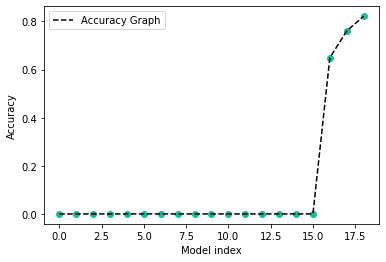

In [38]:
import matplotlib.pyplot as plt
i = []
for j in range(n):
  i.append(j)
print(model_Accuracy)
print(i)
plt.plot(i, model_Accuracy, label = "Accuracy Graph", color='black', linestyle='dashed')

plt.xlabel('Model index')
plt.ylabel('Accuracy')
plt.scatter(i, model_Accuracy, color='#1ABC9C')

plt.legend()

Text(0, 0.5, 'Accuracy')

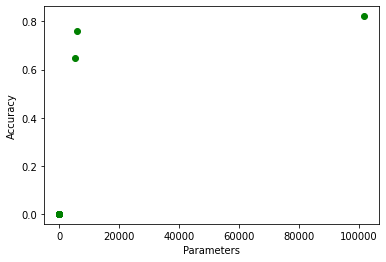

In [39]:
plt.scatter(model_Parameters, [model_Accuracy], color='green')
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
# plt.scatter(i, model_Parameters, color='blue')

